In [2]:
import os
from pathlib import Path
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from coco.coco import COCO
from itertools import chain, combinations
import glob
import cv2
from skimage.measure import label, regionprops

%matplotlib inline

In [3]:
split = 'val_sample'

# # reds
# label_dir = '/data/shared/PartImageNet/'
# root = Path('/data/shared/PartImageNet/PartBoxSegmentations')

# reds5k
label_dir = '/data1/chawins/PartImageNet/'
root = Path('/data1/chawins/PartImageNet/PartBoxSegmentations')

# # savio
# label_dir = '/global/scratch/users/nabeel126/PartImageNet/'
# root = Path('/global/scratch/users/nabeel126/PartImageNet/PartBoxSegmentations')

In [4]:
CLASSES = {
    "Quadruped": 4,
    "Biped": 5,
    "Fish": 4,
    "Bird": 5,
    "Snake": 2,
    "Reptile": 4,
    "Car": 3,
    "Bicycle": 4,
    "Boat": 2,
    "Aeroplane": 5,
    "Bottle": 2,
}
CLASSES = dict(sorted(CLASSES.items()))
CLASSES

{'Aeroplane': 5,
 'Bicycle': 4,
 'Biped': 5,
 'Bird': 5,
 'Boat': 2,
 'Bottle': 2,
 'Car': 3,
 'Fish': 4,
 'Quadruped': 4,
 'Reptile': 4,
 'Snake': 2}

In [5]:
PATHS = {
    "train": (root / "train", root / "image_labels" / 'train.json', root / "annotations" / 'train.json'),
    "val": (root / "val", root / "image_labels" / 'val.json', root / "annotations" / 'val.json'),
    "test": (root / "test", root / "image_labels" / 'test.json', root / "annotations" / 'test.json' ),
    "train_sample": (root / "train", root / "image_labels" / 'train_sample.json', root / "annotations" / 'train_sample.json'),
    "val_sample": (root / "val", root / "image_labels" / 'val_sample.json', root / "annotations" / 'val_sample.json'),
    "test_sample": (root / "test", root / "image_labels" / 'test_sample.json', root / "annotations" / 'test_sample.json' ),
}

os.makedirs(root / "train", exist_ok=True)
os.makedirs(root / "val", exist_ok=True)
os.makedirs(root / "test", exist_ok=True)
os.makedirs(root / "image_labels", exist_ok=True)
os.makedirs(root / "annotations", exist_ok=True)

In [6]:
partimagenet_id2name = {}

categories_json = []

part_id = 0
categories_json.append(
    {'supercategory': 'background',
    'id': 0,
    'name': 'background'}
)
partimagenet_id2name[part_id] = 'background'
part_id += 1

for part_imagenet_class in CLASSES:
    for id in range(CLASSES[part_imagenet_class]):
        categories_json.append(
            {'supercategory': part_imagenet_class,
            'id': part_id,
            'name': f'{part_imagenet_class}_{part_id}'}
        )
        partimagenet_id2name[part_id] = f'{part_imagenet_class}_{part_id}'
        part_id += 1


# Serializing json
json_object = json.dumps(partimagenet_id2name, indent=4)
id2name_filename = os.path.join(label_dir, 'id2name.json')
with open(id2name_filename, "w") as outfile:
    outfile.write(json_object)
    


In [7]:
sample_proportion = 0.102

np.random.seed(1234)

images_json = []
annotations_json = []

image_to_label = {}

global_image_id = 0
image_part_id = 0
for class_label, part_imagenet_class in enumerate(CLASSES):
    print('part_imagenet_class', part_imagenet_class)
    # get filenames of all segmentation masks
    if '_sample' in split:
        seg_label_path = os.path.join(label_dir, f"PartSegmentations/All/{split.replace('_sample', '')}/{part_imagenet_class}/*.tif")
    else:
        seg_label_path = os.path.join(label_dir, f'PartSegmentations/All/{split}/{part_imagenet_class}/*.tif')
    seg_filenames = glob.glob(seg_label_path)
    
    if '_sample' in split:
        np.random.shuffle(seg_filenames)
        seg_filenames = seg_filenames[:int(sample_proportion * len(seg_filenames))]
#         print(len(seg_filenames))

    # iii = 0
    for filename in seg_filenames:
        # load segmentation
        im = Image.open(filename)
        width, height = im.size
        imarray = np.array(im)

        image_name = filename.split('/')[-1]
        image_id = image_name[:-4]    

        jpeg_image_name = image_id + '.JPEG'
        folder_id = image_id.split('_')[0]

        images_json.append({
            'file_name': f'{folder_id}/{jpeg_image_name}',
            'height': height,
            'width': width,
            'id': global_image_id
            })

        image_to_label[global_image_id] = class_label

        # get unique labels
        image_labels = list(np.unique(imarray))
        # print(image_labels)
        # if class_label == 0:
        # print(image_labels)
        # iii += 1
        # if iii == 2:
        #     break

        
        # remove background class
        if 0 in image_labels:
            image_labels.remove(0)

        assert len(image_labels) <= CLASSES[part_imagenet_class]

        

        for index, part_label in enumerate(image_labels):         
            # get sementation mask for object_id
            mask = (imarray == part_label) * 1
            mask = np.uint8(mask)

            lbl_0, num_regions = label(mask, return_num=True, connectivity=1) 
            props = regionprops(lbl_0)

            label_txt_lines = []
            for prop_index, prop in enumerate(props):
                min_row, min_col, max_row, max_col = prop.bbox

                bbox_width = max_col - min_col
                bbox_height = max_row - min_row

                cur_part_bbox = [min_col, min_row, bbox_width, bbox_height]

                annotations_json.append({
                    'image_id': global_image_id,
                    'bbox': cur_part_bbox,
                    'category_id': int(part_label),
                    'id': image_part_id,
                    'area': bbox_width * bbox_height,
                    'iscrowd': 0
                })
                image_part_id += 1
                
#                 annotations_json.append({
#                     'image_id': global_image_id,
#                     'bbox': cur_part_bbox,
#                     'category_id': int(part_label),
#                     'id': f'{image_id}_{index}_{prop_index}',
#                     'area': bbox_width * bbox_height,
#                     'iscrowd': 0
#                 })
        global_image_id += 1

part_imagenet_class Aeroplane
part_imagenet_class Bicycle
part_imagenet_class Biped
part_imagenet_class Bird
part_imagenet_class Boat
part_imagenet_class Bottle
part_imagenet_class Car
part_imagenet_class Fish
part_imagenet_class Quadruped
part_imagenet_class Reptile
part_imagenet_class Snake


In [8]:
global_image_id

238

In [9]:
len(images_json)

238

In [12]:
# Serializing json
json_object = json.dumps(image_to_label, indent=4)
print(PATHS[split][1])
with open(PATHS[split][1], "w") as outfile:
    outfile.write(json_object)
    

/data1/chawins/PartImageNet/PartBoxSegmentations/image_labels/val_sample.json


In [13]:
part_imagenet_bbox_json = {
    'images': images_json,
    'annotations': annotations_json,
    'categories': categories_json
}

# Serializing json
json_object = json.dumps(part_imagenet_bbox_json, indent=4)
 
with open(PATHS[split][2], "w") as outfile:
    outfile.write(json_object)
    

In [9]:
# import os, sys
# import json
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

from DINO.main import build_model_main
from DINO.util.slconfig import SLConfig
from DINO.datasets import build_dataset
from DINO.util.visualizer import COCOVisualizer
from DINO.util import box_ops

/home/nab_126/miniconda3/envs/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# load partimagenet names
with open(id2name_filename) as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

In [11]:
model_config_path='DINO/config/DINO/DINO_4scale.py'
args = SLConfig.fromfile(model_config_path) 
args.dataset_file = 'partimagenet'
args.fix_size = False
dataset_val = build_dataset(image_set='val', args=args)   

data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704,
    736,
    768,
    800
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [27]:
plot_index = 1000
image, targets = dataset_val[plot_index]
for anno in annotations_json:
    if anno['image_id'] == plot_index:
        print(anno)
        
targets

{'boxes': tensor([[0.4330, 0.3587, 0.2380, 0.1573],
         [0.4700, 0.2813, 0.0040, 0.0027],
         [0.5800, 0.4200, 0.2880, 0.2747],
         [0.6490, 0.4040, 0.0020, 0.0027],
         [0.6190, 0.4213, 0.1260, 0.0693],
         [0.4620, 0.4733, 0.0880, 0.0667],
         [0.6470, 0.5493, 0.0820, 0.0533],
         [0.7390, 0.5693, 0.0580, 0.1307]]),
 'labels': tensor([27, 28, 28, 28, 29, 29, 29, 30]),
 'image_id': tensor([1000]),
 'area': tensor([3.1933e+04, 9.0965e+00, 6.7460e+04, 4.5483e+00, 7.4501e+03, 5.0031e+03,
         3.7296e+03, 6.4631e+03]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0]),
 'orig_size': tensor([375, 500]),
 'size': tensor([ 800, 1066])}

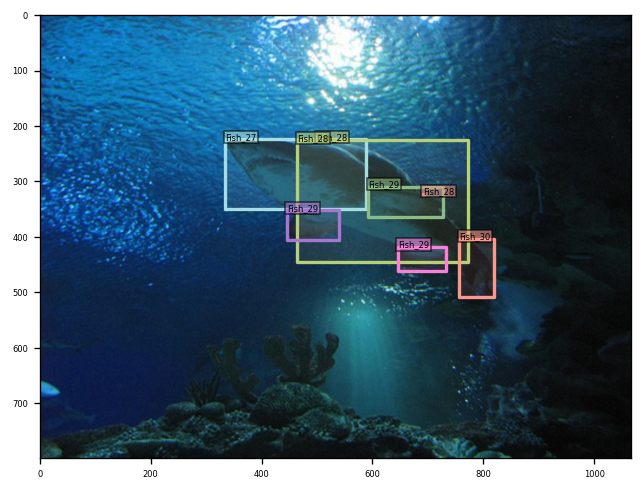

In [28]:
# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

In [6]:
# Opening JSON file
with open(PATHS[split][1], 'r') as openfile:
    json_object = json.load(openfile)

In [9]:
json_object[str(8526)]

8

In [23]:
from part_model.dataloader.part_imagenet import PartImageNetBBOXDataset

img_folder, class_label_file, ann_file = PATHS[split]
print(img_folder, class_label_file, ann_file)
# dataset = PartImageNetBBOXDataset(
#         img_folder, 
#         ann_file, 
#         transforms=None, 
#         return_masks=False,
#         aux_target_hacks=aux_target_hacks_list
#     )

ModuleNotFoundError: No module named 'panoptic_parts.utils.panoptic_parts'

In [6]:
from DINO.datasets.coco import CocoDetection
# dataset = CocoDetection(img_folder, ann_file, 
#         transforms=make_coco_transforms(image_set, fix_size=args.fix_size, strong_aug=strong_aug, args=args), 
#         return_masks=False,
#         aux_target_hacks=aux_target_hacks_list,
#     )

img_folder, ann_file = PATHS[split]
print(img_folder, ann_file)
dataset = CocoDetection(img_folder, ann_file, 
        transforms=None, 
        return_masks=False,
        aux_target_hacks=aux_target_hacks_list
    )

/home/nab_126/miniconda3/envs/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/data/shared/PartImageNet/PartBoxSegmentations/train /data/shared/PartImageNet/PartBoxSegmentations/annotations/train.json
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [7]:
for obj in json_object['annotations']:
    if obj['image_id'] == 0:
        # print(obj)
        print(obj['bbox'])

[28, 271, 178, 80]
[205, 248, 525, 101]
[301, 190, 151, 81]
[633, 268, 134, 22]
[248, 325, 368, 70]
[585, 151, 167, 106]
